### Importing useful libraries and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import warnings
warnings.filterwarnings('ignore')

### Loading and exploring the raw dataset

In [2]:
dataset_og = pd.read_csv("Internet Firewall Data.csv")
dataset_og

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,314,192,122,6,15,4,2,allow
65528,50964,80,13485,80,4680740,67312,4613428,4675,77,985,3690,allow
65529,54871,445,0,0,70,70,0,1,0,1,0,drop
65530,54870,445,0,0,70,70,0,1,0,1,0,drop


In [3]:
print (type(dataset_og))
print (dataset_og.shape)
dataset_og

<class 'pandas.core.frame.DataFrame'>
(65532, 12)


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,314,192,122,6,15,4,2,allow
65528,50964,80,13485,80,4680740,67312,4613428,4675,77,985,3690,allow
65529,54871,445,0,0,70,70,0,1,0,1,0,drop
65530,54870,445,0,0,70,70,0,1,0,1,0,drop


In [4]:
print ("Number of unique classes: ")
print (len(list(dataset_og.Action.unique())))
print()

print ("Classes: ")
classes = list(dataset_og.Action.unique())
print (classes)

Number of unique classes: 
4

Classes: 
['allow', 'drop', 'deny', 'reset-both']


### Pre-processing begins

In [5]:
#Retaining only the top 4 features as obtained from the Feature Analysis

dataset_significant = dataset_og[['Destination Port', 'NAT Source Port', 'Elapsed Time (sec)', 'pkts_received', 'Action']]
dataset_significant

,Destination Port,NAT Source Port,Elapsed Time (sec),pkts_received,Action
0,53,54587,30,1,allow
1,3389,56258,17,9,allow
2,50321,43265,1199,1,allow
3,3389,50553,17,7,allow
4,443,45848,16,18,allow
...,...,...,...,...,...
65527,80,13237,15,2,allow
65528,80,13485,77,3690,allow
65529,445,0,0,0,drop
65530,445,0,0,0,drop


In [6]:
#Scaling the data (no need to encode labels for the unsupervised k-means clustering)

columns_to_scale = dataset_significant.iloc[:, 0:4]

scaler = MinMaxScaler()
scaled_columns = scaler.fit_transform(columns_to_scale)

dataset_scaled = dataset_significant
dataset_scaled.iloc[:, 0:4] = scaled_columns

dataset_scaled

,Destination Port,NAT Source Port,Elapsed Time (sec),pkts_received,Action
0,0.000809,0.832944,0.002772,0.000003,allow
1,0.051713,0.858442,0.001571,0.000028,allow
2,0.767849,0.660182,0.110772,0.000003,allow
3,0.051713,0.771389,0.001571,0.000021,allow
4,0.006760,0.699596,0.001478,0.000055,allow
...,...,...,...,...,...
65527,0.001221,0.201984,0.001386,0.000006,allow
65528,0.001221,0.205768,0.007114,0.011277,allow
65529,0.006790,0.000000,0.000000,0.000000,drop
65530,0.006790,0.000000,0.000000,0.000000,drop


In [7]:
x =  dataset_scaled.iloc[:, 0:4]
x

,Destination Port,NAT Source Port,Elapsed Time (sec),pkts_received
0,0.000809,0.832944,0.002772,0.000003
1,0.051713,0.858442,0.001571,0.000028
2,0.767849,0.660182,0.110772,0.000003
3,0.051713,0.771389,0.001571,0.000021
4,0.006760,0.699596,0.001478,0.000055
...,...,...,...,...
65527,0.001221,0.201984,0.001386,0.000006
65528,0.001221,0.205768,0.007114,0.011277
65529,0.006790,0.000000,0.000000,0.000000
65530,0.006790,0.000000,0.000000,0.000000


In [8]:
y = LabelEncoder().fit(dataset_scaled.iloc[:, -1]).transform(dataset_scaled.iloc[:, -1])
y.shape, y

((65532,), array([0, 0, 0, ..., 2, 2, 2]))

### Working with k-Means Clustering

In [9]:
k_means = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10, 
                 random_state=42, tol=0.0001, verbose=0)
k_means.fit(x) #Fitting on all of the data

KMeans(algorithm='auto', n_clusters=4, random_state=42)

In [10]:
k_means.cluster_centers_, k_means.labels_

(array([[2.08901753e-02, 4.39661362e-01, 9.11805507e-03, 4.90421682e-04],
        [6.71238798e-01, 5.95784623e-02, 4.90682283e-03, 2.03445009e-05],
        [3.55843672e-02, 3.70190617e-02, 2.78780128e-03, 5.84260664e-05],
        [5.76229191e-02, 8.18557257e-01, 1.00969050e-02, 2.85125971e-04]]),
 array([3, 3, 1, ..., 2, 2, 2]))

In [11]:
labels = k_means.labels_

# Perform clustering on new data points
y_pred = k_means.predict(x)    #Would be the same as labels
y_pred.shape, y

((65532,), array([0, 0, 0, ..., 2, 2, 2]))

In [12]:
np.unique(y_pred), np.unique(y)    #Ensuring that the classes are the same as expected

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))

### Model Evaluation

In [13]:
#Inertia
inertia = k_means.inertia_
print("Inertia:", inertia)

#Silhouette Score
silhouette_avg = silhouette_score(x, y)
print("Silhouette Score (Actual Labels):", silhouette_avg)

silhouette_avg_pred = silhouette_score(x, k_means.labels_)
print("Silhouette Score (Predicted Labels):", silhouette_avg_pred)

Inertia: 1881.9128881071933
Silhouette Score (Actual Labels): 0.250487658935805
Silhouette Score (Predicted Labels): 0.5778033499071423


In [14]:
#Accuracy

correct_count = 0
incorrect_count = 0
for i in range(len(y)):
    if y[i] == y_pred[i]:
        correct_count += 1
    else: 
        incorrect_count += 1
        
print (correct_count, incorrect_count, correct_count + incorrect_count)
accuracy = correct_count*100/(correct_count + incorrect_count)
print ("Accuracy: ")
print (accuracy)

36546 28986 65532
Accuracy: 
55.76817432704633


In [15]:
#Obtaining a report containing other metrics (Precision, Recall, f1 Score)

report = classification_report(y, y_pred)

print ("Classification Report: ")
print (report)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.35      0.52     37640
           1       0.82      0.70      0.76     14987
           2       0.51      1.00      0.68     12851
           3       0.00      0.04      0.00        54

    accuracy                           0.56     65532
   macro avg       0.58      0.52      0.49     65532
weighted avg       0.86      0.56      0.60     65532



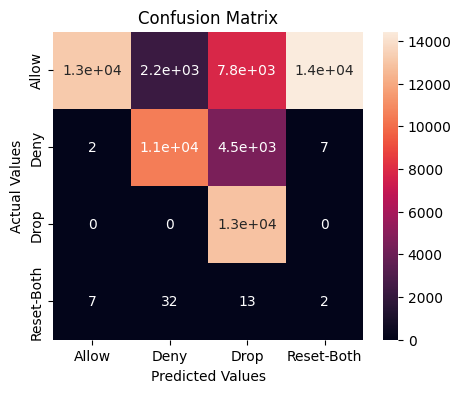

In [16]:
#Confusion Matrix
cm = confusion_matrix(y, y_pred)
cm_df = pd.DataFrame(cm, index = ['Allow', 'Deny', 'Drop', 'Reset-Both'], columns = ['Allow', 'Deny', 'Drop', 'Reset-Both'])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)

plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Visualization of Clusters

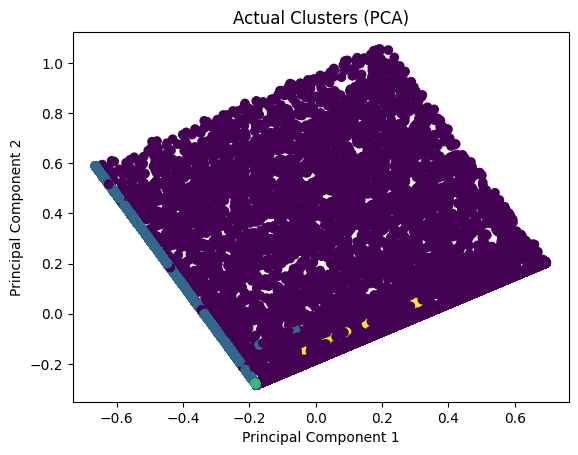

In [17]:
#Visual inspection using PCA

#Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

#Plot the clusters
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y)

#Display legend and show plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Actual Clusters (PCA)')
plt.show()

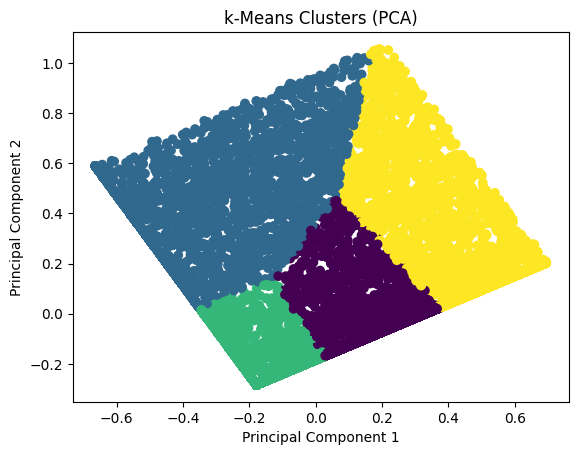

In [18]:
#Plot the clusters
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=k_means.labels_)

#Display legend and show plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('k-Means Clusters (PCA)')
plt.show()

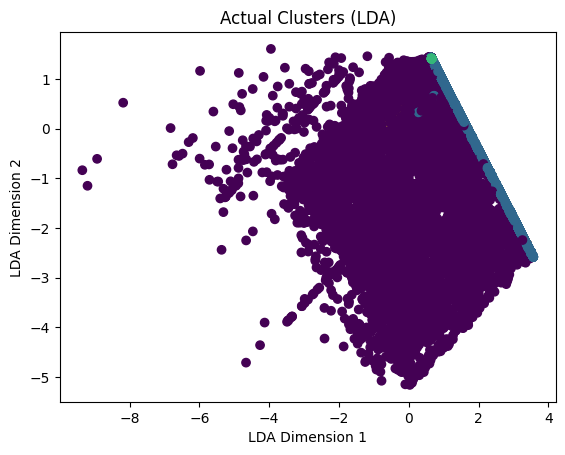

In [19]:
#Visual inspection using LDA

#Apply LDA to reduce the data to 2 dimensions
lda = LDA(n_components=2)
x_lda = lda.fit_transform(x, y)

#Plot the clusters
plt.scatter(x_lda[:, 0], x_lda[:, 1], c=y)

#Display legend and show plot
plt.xlabel('LDA Dimension 1')
plt.ylabel('LDA Dimension 2')
plt.title('Actual Clusters (LDA)')
plt.show()

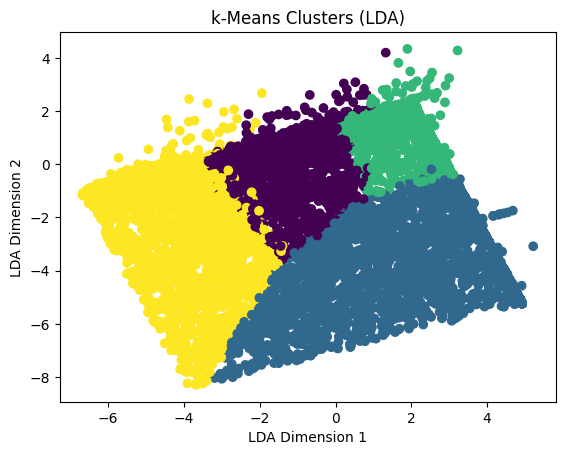

In [20]:
#Visual inspection using LDA

#Apply LDA to reduce the data to 2 dimensions
x_lda = lda.fit_transform(x, k_means.labels_)

#Plot the clusters
plt.scatter(x_lda[:, 0], x_lda[:, 1], c=k_means.labels_)

#Display legend and show plot
plt.xlabel('LDA Dimension 1')
plt.ylabel('LDA Dimension 2')
plt.title('k-Means Clusters (LDA)')
plt.show()

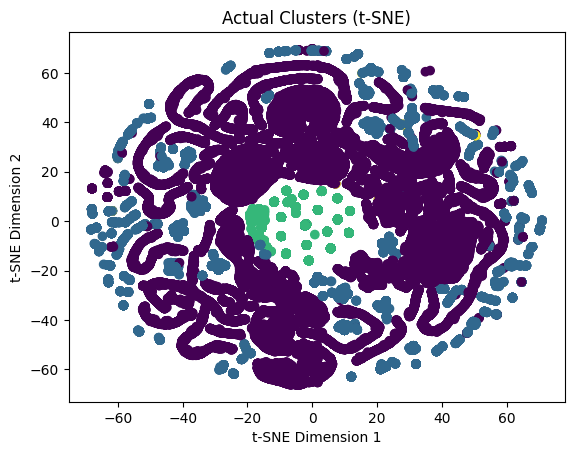

In [21]:
#Visual inspection using t-SNE

#Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x)

#Plot the clusters
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y)

#Display legend and show plot
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Actual Clusters (t-SNE)')
plt.show()

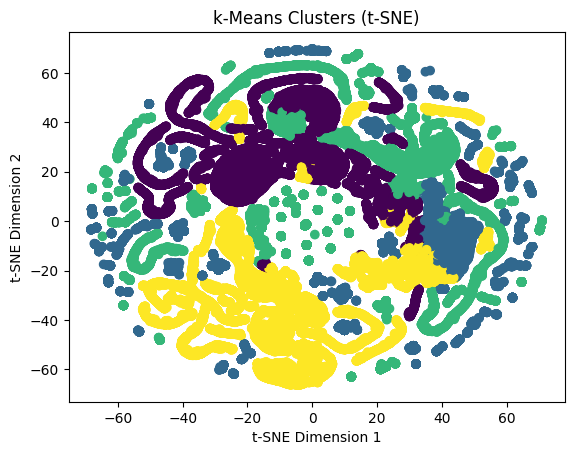

In [22]:
#Plot the clusters
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=k_means.labels_)

#Display legend and show plot
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('k-Means Clusters (t-SNE)')
plt.show()